# Anomaly main class

In [5]:
import collections
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
from numbers import Number
from statsmodels.robust.scale import mad
from scipy.stats import t
from scipy.signal import medfilt


class AnomalyDetection:
    """ 
    AnomalyDetection objects detect anomalous data points from input series

    """

    def __init__(self, series, dates=None):
        """
        Note:
            list comprehension standardizes series to np.arrays

        Args:
            series (Optional[int] or DataFrame or Dict): 1D or 2D group  of numerical values or Dataframe 
            dates [str]: List of dates corresponding to series. Multiple formats are supported
        """
        self.series = [np.array(x) for x in AnomalyDetection.standardize_data(series)]
        self.dates = dates

    @staticmethod
    def standardize_data(series):
        """
        Static method that standardizes series to 2D list of numpy arrays
        Note:
            Type errors that aren't in the first position of the iterable won't be caught
        Args:
            series (Optional[int] or DataFrame or Dict): 1D or 2D group  of numerical values or Dataframe
        Returns:
            List of numpy arrays containing series, raises ValueError if problem
        """

        lists = []

        if len(series) == 0:
            raise ValueError('Empty series not allowed')
        # python strings will pass iterable so need to explicitly check
        if isinstance(series, str):
            raise ValueError('Series could not be parsed, must be iterable')
        # DataFrame isn't a standard iterable, .values returns np.array()
        if isinstance(series, pd.DataFrame):
            df = series
            for i in df.columns:
                lists.append(df[i].values)
            return lists
        # can't select from dict with [0] index so need separate case
        elif isinstance(series, dict):
            for sub in series.values():
                lists.extend(AnomalyDetection.standardize_data(sub))
            return lists
        # standard use case
        elif isinstance(series, collections.Iterable):
            if isinstance(series[0], Number):
                lists.append(series)
                return lists
            # if it is a list of lists, then it recurses into this function again
            elif isinstance(series[0], collections.Iterable):
                for sub in series:
                    lists.extend(AnomalyDetection.standardize_data(sub))
                return lists

        raise ValueError('Series could not be parsed, must be iterable')

    @staticmethod
    def seasonal_h_esd(inputs, a=.025, frequency=3, start=None, end=None):
        """
        Static method that generates anomalies from the given series using
            twitter anomaly detection algorithms
        Note:
            The decomposition trend values become NULL near the bounds of the series depending on the frequency value
            if we use the trend value of seasonal_decompose method.
                This is a stats_model limitation and has been dealt with using an imputation.
        Args:
            inputs (np.array[int]): time series of numerical values
            a (float): a confidence level(alpha) for the algorithm to use to determine outliers
            frequency (int): the frequency of season of the data (instances to complete cycle) 
            start (int): the first index in the series to check for anomalies
            end (int): the last index in the series to check for anomalies
        Returns:
            List of tuple pairs (anomaly,index) indicating the anomalies for input series
        """

        raw = np.copy(inputs)  # copy so that you keep inputs immutable
        data = sm.tsa.seasonal_decompose(raw, freq=frequency)  # STL decomposition algorithm from stats_model
        trend = medfilt(raw, 301)  # Median filter algorithm from sciPy
        residual = data.observed - trend - data.seasonal  # Normalizing time series using de-trending and differencing

        median = np.nanmedian(residual)

        # need to impute NULL residuals to median (Required mainly if we use STL trend component)
        res = []
        for i in range(len(residual)):
            v = median if np.isnan(residual[i]) else residual[i]
            res.append((v, i))
        return residual, data.seasonal, trend, AnomalyDetection.esd_test_robust(inputs, res, start, end, a)


    @staticmethod
    def esd_test_robust(inputs, res, start=None, end=None, a=.025):
        """
        Static method that finds anomalies in a sample of normally distributed random variables

        Note:
          An assumption is made that the input data is normal. Grubb's test uses the chi squared 
          distribution and n degrees of freedom to account for small sample sizes

        Args:
            inputs (np.array[int]): time series of numerical values
            start (int): the first index in the series to check for anomalies
            end (int): the last index in the series to check for anomalies
            a (float): a confidence level(alpha) for the algorithm to use to determine outliers
        """
        outliers = []
        values = res
        start = 0 if start is None else start
        end = len(values) - 1 if end is None else end
        check = True
        count = 1

        # run ESD test until the furthest remaining point fails
        while check:
            g = 0
            val = 0
            n = len(values)-len(outliers)
            index = 0
            ind = 0
            series = [x[0] for x in values]
            series = np.array(series)
            m = np.nanmean(series)
            u = np.nanmedian(series)
            s = mad(series, c=0.6745, axis=0, center=u)    #MAD is median absolute deviation

            # find residual with largest z value or distance from median
            for j in range(len(values)):
                if j >= start and j <= end:
                    v = values[j][0]
                    k = values[j][1]
                    val = v if abs((u - v) / s) > g else val
                    index = int(j) if abs((u - v) / s) > g else index
                    ind = k if abs((u - v) / s) > g else ind
                    g = abs((u - v) / s) if abs((u - v) / s) > g else g #g holds the value of largest test statistic

            # generate critical value for esd test
            critical = ((n - 1) / math.sqrt(n)) * math.sqrt(
                math.pow(t.ppf(a / (2 * n), n - 2), 2) / (n - 2 + math.pow(t.ppf(a / (2 * n), n - 2), 2)))
            if g > critical:
                outliers.append((inputs[ind], ind, 1 - critical / g))  #1 - critical / g is the Anomaly score
                count = count + 1
            else:
                check = False

            # remove value for next iteration of the test by imputing to new mean
            values[index] = (m * n - values[index]) / (n - 1)
        return outliers


    @staticmethod
    def derivative(y):
        """
        Returns derivative of series y

        Args:
            y (np.array[float]): series of values
        Returns
            np.array[float] of changes between values 
        """
        dx = 0.001
        dy = np.diff(y) / dx
        return np.multiply(dy, .001)

    @staticmethod
    def seasonality(y):
        """
        Generates the frequency of a time series
        Notes:
           computes frequency by checking average number of times
           for the derivative to change sign 3 times
        Args:
            y (np.array[float]): series of values
        Returns
            int representing frequency 
        """
        vals = AnomalyDetection.derivative(y)
        sign = 1 if vals[0] >= 0 else -1
        changes = 0
        count = 0
        counts = []
        for val in vals:
            count += 1
            if val * sign < 0:
                sign = -1 if sign >= 0 else 1
                changes += 1
                if changes == 3:
                    changes = 0
                    counts.append(count)
                    count = 0
        try:
            return int(np.nanmean(np.array(counts[1:])))
        except Exception as e:
            print e
            return 3

    @staticmethod
    def detect_anomalies(series, start, end, a=0.025):
        """
        Finds anomalies in a series.
        Args:
            series (np.array[float]): the time series values
            start (int): the first index in the series to check for anomalies
            end (int): the last index in the series to check for anomalies
        Returns [tuples] containing anomalies, their index, their value, and their ESD score
        """
        inputs = np.copy(series)
        residual, seasonality, trend, potential = \
            AnomalyDetection.seasonal_h_esd(inputs, a=a, frequency=AnomalyDetection.seasonality(inputs), start=start, end=end)

        anomalies = sorted(potential, key=lambda x: x[1])
        return residual, seasonality, trend, anomalies


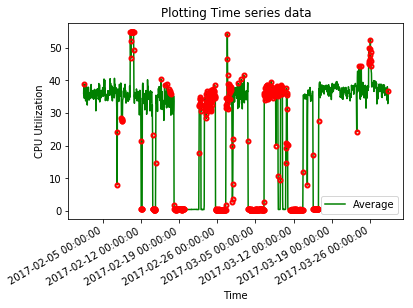

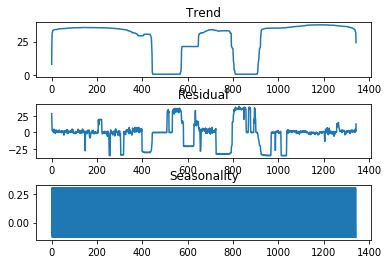

In [6]:
import datetime
import json
import time
import dateparser
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from collections import OrderedDict
from numpy import *
from raiseanomaly import AnomalyDetection


# Handling data for the Anomaly Detection Algorithm

def loadData(filename):
    with open(filename) as data_file:
        return json.load(data_file, object_pairs_hook=OrderedDict)

def createDataMap(data, type):
    datamap = {}
    for dataItr in data["Datapoints"]:
        datamap[dataItr["Timestamp"]] = dataItr[type]
    return datamap

dataStream_avg = loadData('data/cloudwatch-CPUUtilization-Average.json')

sorted_obj_avg = dict(dataStream_avg)
sorted_obj_avg['Datapoints'] = sorted(dataStream_avg['Datapoints'], key=lambda x: int(time.mktime(dateparser.parse(x['Timestamp']).timetuple())), reverse=False)
datamap_obj_avg = createDataMap(sorted_obj_avg, "Average")

xar = []
avg = []

for data in sorted_obj_avg["Datapoints"]:
    for attribute in data:
        if attribute == "Timestamp":
            xar.append(data[attribute])
            avg.append(datamap_obj_avg[data[attribute]])


# Plotting anomalies in graph

converted_dates = map(datetime.datetime.strptime, xar, len(xar)*['%Y-%m-%dT%H:%M:%SZ'])
x_axis = converted_dates
fig = plt.figure()
plt.plot(x_axis, avg, 'g')


model = AnomalyDetection(avg, x_axis)    #Instantiate the object of Anomaly Detection class and call the main function to detect anomalies
residual, seasonality, trend, anomalies = model.detect_anomalies(avg, 1, len(avg), 0.02)

days = mdates.DayLocator()
hours = mdates.HourLocator(interval=2)
fig.autofmt_xdate()
ax = plt.gcf().axes[0]
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.xlabel('Time')
plt.ylabel('CPU Utilization')
plt.title('Plotting Time series data')
plt.legend(['Average'])


circle_rad = 2  # This is the radius, in points
for anomalyVal, index, score in anomalies:
    ax.plot(x_axis[index], anomalyVal, 'o', ms=circle_rad * 2, mec='r', mfc='none', mew=2)


# Plotting the trend of time series
fig2 = plt.figure()
ax1 = fig2.add_subplot(311)
ax1.set_title("Trend")
fig2.subplots_adjust(hspace=.5)
ax1.plot(trend)

# Plotting the residual of time series
ax2 = fig2.add_subplot(312)
ax2.set_title("Residual")
fig2.subplots_adjust(hspace=.5)
ax2.plot(residual)

# Plotting the seasonality of time series
ax3 = fig2.add_subplot(313)
ax3.set_title("Seasonality")
fig2.subplots_adjust(hspace=.5)
ax3.plot(seasonality)

# Display the plots
plt.show()